# Vectorizing and Clustering

This notebook contains the code for the initial feature creation using a Tfidf-vectorizer applied to the abstract of each paper. Since it would be time consuming to run feature creation each day when new data is collected, the initial data set of ~18,000 papers was used to fit the vectorizer which is then applied generally for all future papers. This fit "model" is pickled and utilized during the daily collection.

I also investigate here parameters for clustering. Since I am dealing with text data, which is often very messy, I am not expecting very strong clustering, but the objective is to create clusters with more generalized features such that a single paper does not skew recommendations too highly. I perform a "grid search" of sorts, with the metric being silhouette score. In addition, another metric evaluated was the difference between the best cluster and the "true cluster" which is elaborated more below

In [1]:
# Import relevant libraries

import numpy as np
import pandas as pd
import pyodbc
import re
import random
import csv
import pickle
import matplotlib.pyplot as plt
from scipy import sparse
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Pull all of the collected data from the SQL database and create a dataframe

cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=ga-cc12-s5.database.windows.net;DATABASE=capstone;UID=[REDACTED];PWD=[REDACTED]')
cursor = cnxn.cursor()
info = list(cursor.execute("SELECT abstract, id, title, journal FROM papers").fetchall())
papers = {'abstract':[x[0] for x in info],
          'id':[x[1] for x in info],
          'title':[x[2] for x in info],
          'journal':[x[3] for x in info]}
cnxn.close()
df = pd.DataFrame.from_dict(papers)
df.sort_values(by='id', inplace=True)
df.head()

,abstract,id,title,journal
8013,The possibility of the inference of neural net...,1,Applicability of Minifloats for Efficient Calc...,"Optoelectronics, Instrumentation and Data Proc..."
8014,This paper first considers an approach based o...,2,Application of Capacitive Microstructures as A...,"Optoelectronics, Instrumentation and Data Proc..."
8015,A new method is proposed for automatic classif...,3,Classification of Seismoacoustic Emission Sour...,"Optoelectronics, Instrumentation and Data Proc..."
8016,Constitutive steady-state creep equations are ...,4,Construction of Constitutive Equations for Ort...,Journal of Applied Mechanics and Technical Phy...
8017,Known models were used to investigate the dela...,5,Delamination of a Coating from an Elastic Subs...,Journal of Applied Mechanics and Technical Phy...


In [3]:
# Process abstracts by removing non-alpha characters, and lemmatize words

wl = WordNetLemmatizer()

def parser(title):
    
    '''Removes any non-alphabetical characters, converts to lower case, and lemmatizes each word in a document'''
    
    letters = re.sub('[^a-zA-Z]', ' ', title)
    letters = letters.lower()
    words = re.split('\s+', letters)
    words = [wl.lemmatize(x) for x in words]
    return (' '.join(words))

df['p_abstract'] = [parser(x) for x in df['abstract']]

In [6]:
# Create vectorizer, fit and transform the data set

tv = TfidfVectorizer(min_df=50, max_df=0.95, max_features=10000, stop_words='english')
features = tv.fit_transform(df['p_abstract'])

In [7]:
# Pickle the fit transformer as well as saving the calculated features for future reference

pickle.dump(tv, open('../data/vectorizer.csv', 'wb'))
sparse.save_npz('../data/features.npz', features)

In [8]:
# Calculate the cosine similarity between all elements against all other elements. This is not utilized in the actual app since it is computationally intensive and unnecessary, but is conducted here in order to allow for random sampling for testing clustering

cs = cosine_similarity(features, features)

### Clustering

I am interested in trying to cluster a user's favorited articles because often times researchers will be searching for papers on several different topics at once. Rather than try to match each paper individually, clustering would allow for matching against the overall features of the group, which would help mitigate "outliers," or papers that may have hyper-focused topics. Instead, I am looking to parse more general trends.

What I am interested in testing for here is how many papers to "bolster" small sample sets with. If a user has only one or two papers saved, then we can find matches to each individual paper fairly easily. Similarly, if there are a large number of favorites, then we can conduct clustering fairly easily (though the resulting clusters may still not be distinct due to the nature of language data). However, in the middle ground, there might be too few papers to cluster well even if there are different topics of interest. To try and correct for this, I add the next x best matches based on cosine similarity calculated previously, and then perform clustering on these bolstered groups. In this way, I know the "true" number of clusters (a paper plus its best matches). By finding the number of clusters that the K-Means algorithm gives the highest silhouette score to, I calculate the difference between the best K-Means and the true cluster number and use that as another metric for efficacy.

In the following code, z = number of added papers, t = number of random seed papers (i.e. number of true clusters) and y is the number of clusters for the K-Means model. Each permutation was repeated 20 times.

In [9]:
all_scores = []
diff = []
for z in [3,4,5,6,7]:
    z_score = 0
    z_diff = 0
    for t in [2,3,4,5,6,7]:
        max_scores = []
        max_n = []
        for x in range(20):
            papers = []
            for blah in range(t):
                index = random.randrange(0,18000)
                top = sorted(list(cs[index]))[-(z+1):]
                papers += [list(cs[index]).index(w) for w in top]
            groups = [features[num] for num in papers]
            scores = []
            for y in range(2,8):
                km = KMeans(n_clusters=y)
                km.fit(groups)
                scores.append(silhouette_score(groups, km.predict(groups)))
            max_scores.append(max(scores))
            max_n.append(scores.index(max(scores))+2)
        z_diff += abs(np.mean(max_n)-t)
        z_score += np.mean(max_scores)
    all_scores.append(z_score/6)
    diff.append(z_diff)
print('Clustering for X similar papers added for each paper in sample')
print('Silhouette Score:', [round(x,2) for x in all_scores])
print('Total difference in estimated clusters:', [round(x,2) for x in diff])

Clustering for X similar papers added for each paper in sample
Silhouette Score: [0.27, 0.27, 0.26, 0.25, 0.26]
Total difference in estimated clusters: [4.35, 6.85, 7.25, 7.6, 8.55]


From the grid search, we calculate the total silhouette score and total difference in estimated clusters. Index of the resulting lists corresponds to the values of z (number of added papers). From this, we find that smaller is better - as we add more papers, both silhouette score decreases and estimated cluster difference increases, so I opt to use 3 added papers. While it is possible that this may lead to overall worse metrics as compared to no bolstering, I believe it will still provide more benefits for recommendations; in a sense this helps combat overfitting to a small sample size

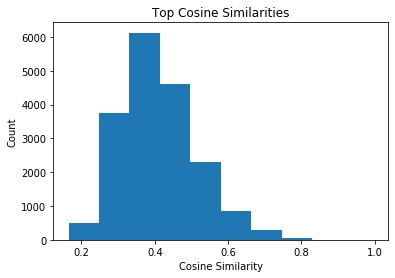

In [20]:
plt.hist([sorted(list(x))[-2] for x in cs])
plt.title('Top Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

Histogram of cosine similarity scores for all papers in the initial data set. I use this to determine what the threshold score should be for considering a paper a match to one another. From this histogram, I selected 0.3 as the cutoff - while it is on the lower side, I decide to err on the side of inclusivity in order to present more matches. It is often that researchers can gain valuable insight from papers that are more tangentially related, and stronger matches will still be given priority